In [1]:

import os
import sys

# append parent directory to path (../notebooks -> ..) this cell should be run once. otherwise it goes one more level up
sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import accelerate
import lovely_tensors as lt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import yaml
from diffusers.optimization import get_scheduler
from omegaconf import OmegaConf
from tqdm.auto import tqdm
from einops import rearrange

from ldns.data.latent_attractor import get_attractor_dataloaders
from ldns.networks import AutoEncoder, CountWrapper
from ldns.utils.plotting_utils import *
from ldns.networks import Denoiser
from diffusers.training_utils import EMAModel
from diffusers.schedulers import DDPMScheduler
# always run from ../ntldm

lt.monkey_patch()
matplotlib.rc_file('matplotlibrc') # mackelab plotting style

%load_ext autoreload
%autoreload 2


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.


In [2]:

cfg_ae = OmegaConf.load("conf/autoencoder-Lorenz_z=8.yaml") # cfg that was saved while training the autoencoder


cfg_yaml = """
denoiser_model:
  C_in: 8 
  C: 64
  num_blocks: 4 
  bidirectional: True
  num_train_timesteps: 1000 # DDPM denoising steps
training:
  lr: 0.001
  num_epochs: 1000
  num_warmup_epochs: 50
  batch_size: 512
  random_seed: 42
  precision: "no"
exp_name: diffusion_Lorenz
"""

cfg = OmegaConf.create(yaml.safe_load(cfg_yaml))
cfg.dataset = cfg_ae.dataset


In [3]:
# save the cfg
with open(f"conf/{cfg.exp_name}.yaml", "w") as f:
    f.write(OmegaConf.to_yaml(cfg))


In [4]:
# print autoencoder config
print(OmegaConf.to_yaml(cfg_ae))


model:
  C_in: 128
  C: 256
  C_latent: 8
  num_blocks: 4
  num_blocks_decoder: 0
  num_lin_per_mlp: 2
dataset:
  system_name: Lorenz
  signal_length: 256
  n_ic: 5000
  mean_rate: 0.3
  split_frac_train: 0.7
  split_frac_val: 0.1
  random_seed: 42
  softplus_beta: 2.0
training:
  lr: 0.001
  weight_decay: 0.01
  num_epochs: 200
  num_warmup_epochs: 10
  batch_size: 512
  random_seed: 42
  precision: bf16
  latent_beta: 0.01
  latent_td_beta: 0.01
  mask_prob: 0.2
exp_name: autoencoder-Lorenz_z=8



In [5]:
# create the autoencoder model and load checkpoint
    
ae_model = AutoEncoder(
    C_in=cfg_ae.model.C_in,
    C=cfg_ae.model.C,
    C_latent=cfg_ae.model.C_latent,
    L=cfg_ae.dataset.signal_length,
    num_blocks=cfg_ae.model.num_blocks,
    num_blocks_decoder=cfg_ae.model.num_blocks_decoder,
    num_lin_per_mlp=cfg_ae.model.get("num_lin_per_mlp", 2),  # default 2
)

ae_model = CountWrapper(ae_model)

ae_model.load_state_dict(torch.load(f"exp/{cfg_ae.exp_name}/model.pt", map_location="cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ae_model = ae_model.to(device)

train_dataloader, val_dataloader, test_dataloader = get_attractor_dataloaders(
    system_name=cfg_ae.dataset.system_name,
    n_neurons=cfg_ae.model.C_in,
    sequence_length=cfg_ae.dataset.signal_length,
    n_ic=cfg_ae.dataset.n_ic,
    mean_spike_count=cfg_ae.dataset.mean_rate * cfg.dataset.signal_length,
    train_frac=cfg_ae.dataset.split_frac_train,
    valid_frac=cfg_ae.dataset.split_frac_val, # test is 1 - train - valid
    random_seed=cfg_ae.training.random_seed, # reproducibility
    batch_size=cfg_ae.training.batch_size,
    softplus_beta=cfg_ae.dataset.get("softplus_beta", 2.0),
)


/tmp/ipykernel_566228/650867952.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_model.load_state_dict(torch.load(f"exp/{cfg_ae.exp_name}/model.pt", map_location="cpu

Simulating Lorenz:   0%|          | 0/5000 [00:00<?, ?it/s]

/mnt/repos/LDNS/ldns/data/latent_attractor.py:85: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(results, dtype=torch.float32)


In [6]:
ae_model

CountWrapper(
  (ae_net): AutoEncoder(
    (encoder_in): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
    (encoder): ModuleList(
      (0-3): 4 x AutoEncoderBlock(
        (time_mixer): FFTConv(
          (activation): Identity()
          (kernel): SSMKernelDPLR()
          (drop): Identity()
          (drop_kernel): Identity()
        )
        (post_tm_scale): Conv1d(256, 256, kernel_size=(1,), stride=(1,), padding=same, groups=256)
        (channel_mixer): Sequential(
          (0): Rearrange('b c l -> b l c')
          (1): Linear(in_features=256, out_features=512, bias=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=512, out_features=256, bias=False)
          (4): Rearrange('b l c -> b c l')
        )
        (norm1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (act1): GELU(approximate='none')

# Set up the accelerator and the latent dataset

In [7]:
# setup the accelerator to load the autoencoder model onto the gpu

# check if signal length is power of 2
if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x


accelerator = accelerate.Accelerator(
    mixed_precision=cfg.training.precision,
    log_with="wandb",
)
#


# prepare the ae model and dataset
(
    ae_model,
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    ae_model,
    train_dataloader,
    val_dataloader,
    test_dataloader,
)


In [8]:

class LatentDataset(torch.utils.data.Dataset):
    """Dataset class to store latents from autoencoder for training the diffusion model.
    init takes a dataloader and an autoencoder model.
    """
    def __init__(
        self, dataloader, ae_model, clip=True, latent_means=None, latent_stds=None
    ):
        """
        Args:
            dataloader: dataloader to get the data from
            ae_model: autoencoder model to encode the data
            clip: whether to clip the latents to -5, 5 (does not change perf, but stabilizes training)
            latent_means: means of the latent dataset (if None, compute from the dataset)
            latent_stds: stds of the latent dataset (if None, compute from the dataset)
        """
        self.full_dataloader = dataloader
        self.ae_model = ae_model
        self.latents = self.create_latents()
        # normalize to N(0, 1)
        if latent_means is None or latent_stds is None:
            self.latent_means = self.latents.mean(dim=(0, 2)).unsqueeze(0).unsqueeze(2)
            self.latent_stds = self.latents.std(dim=(0, 2)).unsqueeze(0).unsqueeze(2)
        else:
            self.latent_means = latent_means
            self.latent_stds = latent_stds
        self.latents = (self.latents - self.latent_means) / self.latent_stds
        if clip:
            self.latents = self.latents.clamp(-5, 5)

    def create_latents(self):
        """
        Create the latents from the autoencoder.
        """
        latent_dataset = []
        self.ae_model.eval()
        for i, batch in tqdm(
            enumerate(self.full_dataloader),
            total=len(self.full_dataloader),
            desc="Creating latent dataset",
        ):
            with torch.no_grad():
                z = self.ae_model.encode(batch["signal"])
                latent_dataset.append(z.cpu())
        return torch.cat(latent_dataset)

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        return self.latents[idx]


# create the latent dataset
latent_dataset_train = LatentDataset(train_dataloader, ae_model)
latent_dataset_val = LatentDataset(
    val_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
)
latent_dataset_test = LatentDataset(
    test_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
)

Creating latent dataset:   0%|          | 0/7 [00:00<?, ?it/s]

Creating latent dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Creating latent dataset:   0%|          | 0/2 [00:00<?, ?it/s]

latent dataset tensor[3500, 8, 256] n=7168000 (27Mb) x∈[-5.000, 5.000] μ=-0.001 σ=0.983
latent dataset means tensor[1, 8, 1] x∈[-0.451, 0.444] μ=-0.079 σ=0.264 [[[0.045], [0.444], [-0.059], [-0.284], [-0.030], [-0.451], [-0.093], [-0.200]]]
latent dataset stds tensor[1, 8, 1] x∈[0.154, 0.745] μ=0.465 σ=0.226 [[[0.154], [0.654], [0.218], [0.745], [0.239], [0.551], [0.584], [0.577]]]


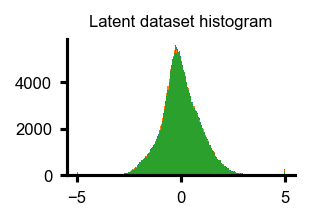

In [9]:

print("latent dataset", latent_dataset_train.latents)
print("latent dataset means", latent_dataset_train.latent_means)
print("latent dataset stds", latent_dataset_train.latent_stds)
plt.figure(figsize=cm2inch(5, 3))
hist = plt.hist(latent_dataset_train.latents[:100].flatten(), bins=200)
hist = plt.hist(latent_dataset_val.latents[:100].flatten(), bins=200)
hist = plt.hist(latent_dataset_test.latents[:100].flatten(), bins=200)

plt.title("Latent dataset histogram")
plt.show()

In [10]:
# sanity check: evaluate the autoencoder on the test set

from ldns.utils.plotting_utils import evaluate_autoencoder

_1, _2 , test_dataloader_longer = get_attractor_dataloaders(
    system_name=cfg_ae.dataset.system_name,
    n_neurons=cfg_ae.model.C_in,
    sequence_length=cfg_ae.dataset.signal_length * 4,
    n_ic=cfg_ae.dataset.n_ic//10,
    mean_spike_count=cfg_ae.dataset.mean_rate * cfg.dataset.signal_length * 4,
    train_frac=cfg_ae.dataset.split_frac_train,
    valid_frac=cfg_ae.dataset.split_frac_val, # test is 1 - train - valid
    random_seed=cfg_ae.training.random_seed,
    batch_size=cfg_ae.training.batch_size//16,
    softplus_beta=cfg_ae.dataset.get("softplus_beta", 2.0),
)

test_dataloader_longer = accelerator.prepare(test_dataloader_longer)


Simulating Lorenz:   0%|          | 0/500 [00:00<?, ?it/s]

/mnt/repos/LDNS/ldns/utils/plotting_utils.py:1240: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[-1].legend()


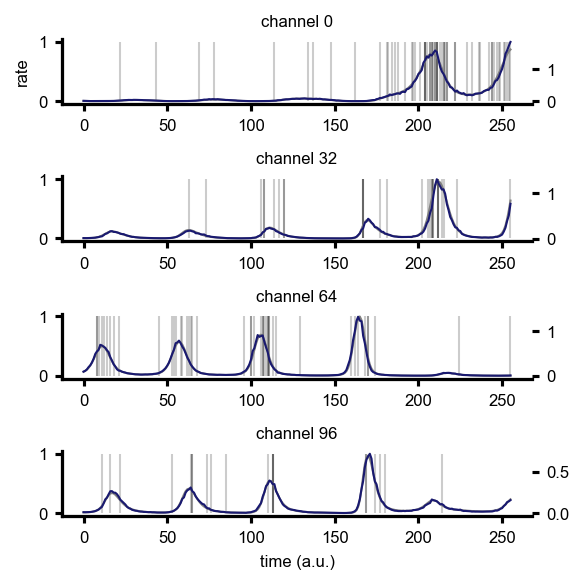

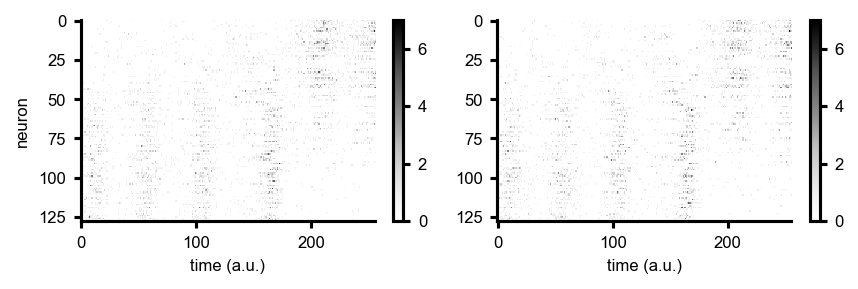

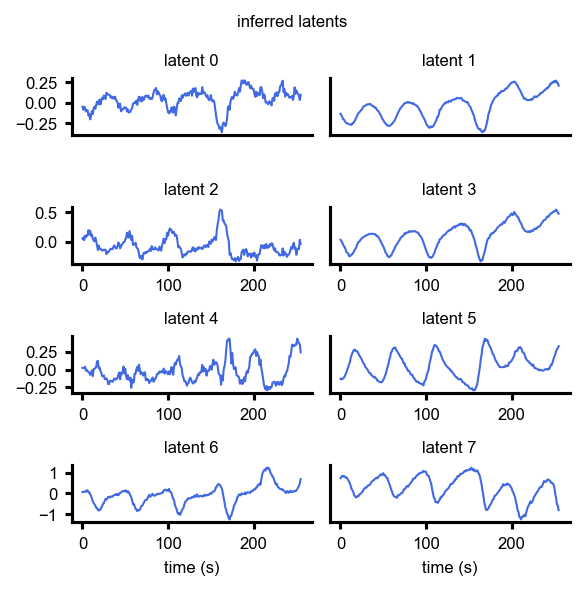

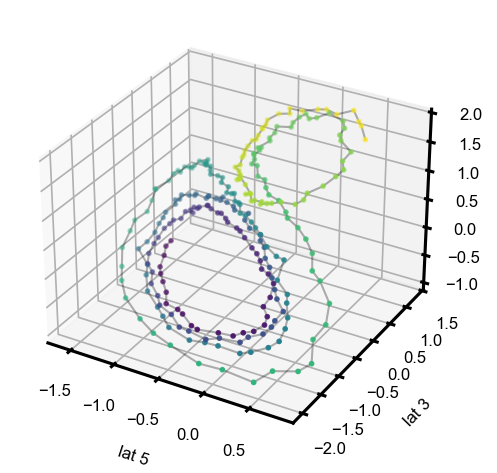

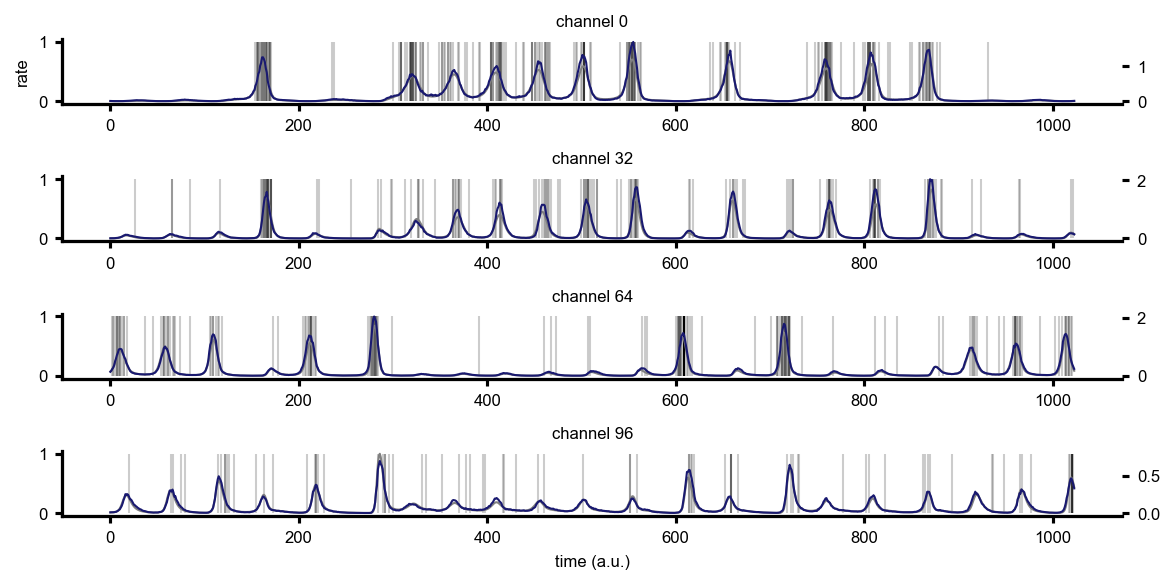

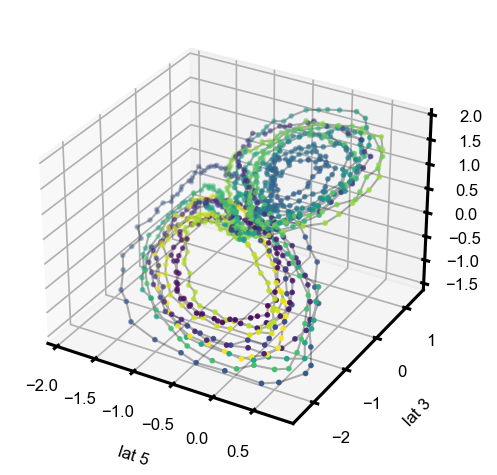

In [11]:

evaluate_autoencoder(ae_model, test_dataloader, test_dataloader_longer, n_latents=8, save=False, idx=10, indices=[1, 5, 3])

In [12]:
# make the denoiser model and scheduler, load the model to the device

denoiser = Denoiser(
    C_in=cfg.denoiser_model.C_in,
    C=cfg.denoiser_model.C,
    L=cfg.dataset.signal_length,
    num_blocks=cfg.denoiser_model.num_blocks,
    bidirectional=cfg.denoiser_model.get("bidirectional", True),
)

scheduler = DDPMScheduler(
    num_train_timesteps=cfg.denoiser_model.num_train_timesteps,
    clip_sample=False,
    beta_schedule="linear", # doesnt support cosine noise schedule for now
)

optimizer = torch.optim.AdamW(
    denoiser.parameters(), lr=cfg.training.lr
)  # default wd=0.01 for now

train_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_train,
    batch_size=cfg.training.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_val,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

test_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_test,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

num_batches = len(train_latent_dataloader)
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=num_batches * cfg.training.num_warmup_epochs,  # warmup for 10% of epochs
    num_training_steps=num_batches * cfg.training.num_epochs * 1.3,  # total number of steps
)

# check if signal length is power of 2
if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x

# prepare the denoiser model and dataset
(
    denoiser,
    train_latent_dataloader,
    val_latent_dataloader,
    test_latent_dataloader,
    lr_scheduler,
) = accelerator.prepare(
    denoiser,
    train_latent_dataloader,
    val_latent_dataloader,
    test_latent_dataloader,
    lr_scheduler,
)

ema_model = EMAModel(denoiser)

In [13]:
ae_model, denoiser

(CountWrapper(
   (ae_net): AutoEncoder(
     (encoder_in): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
     (encoder): ModuleList(
       (0-3): 4 x AutoEncoderBlock(
         (time_mixer): FFTConv(
           (activation): Identity()
           (kernel): SSMKernelDPLR()
           (drop): Identity()
           (drop_kernel): Identity()
         )
         (post_tm_scale): Conv1d(256, 256, kernel_size=(1,), stride=(1,), padding=same, groups=256)
         (channel_mixer): Sequential(
           (0): Rearrange('b c l -> b l c')
           (1): Linear(in_features=256, out_features=512, bias=False)
           (2): GELU(approximate='none')
           (3): Linear(in_features=512, out_features=256, bias=False)
           (4): Rearrange('b l c -> b c l')
         )
         (norm1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
         (norm2): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
         (act1): GE

In [14]:
def sample(
    ema_denoiser,
    scheduler,
    cfg,
    batch_size=1,
    generator=None,
    device="cuda",
    signal_length=None
):  
    """Sample from the denoiser model.
    Args:
        ema_denoiser: EMA model to sample from
        scheduler: scheduler to use for sampling
        cfg: config
        batch_size: batch size
        generator: generator to use for sampling
        device: device to use for sampling
        signal_length: signal length to use for sampling
    
    Returns:
        z_t: sampled latents
    """
    if signal_length is None:
        signal_length = cfg.dataset.signal_length
    z_t = torch.randn(
        (batch_size, cfg.denoiser_model.C_in, signal_length)
    ).to(device)
    ema_denoiser_avg = ema_denoiser.averaged_model
    ema_denoiser_avg.eval()

    scheduler.set_timesteps(cfg.denoiser_model.num_train_timesteps)

    for t in tqdm(scheduler.timesteps, desc="Sampling DDPM"):
        with torch.no_grad():
            model_output = ema_denoiser_avg(
                z_t, torch.tensor([t] * batch_size).to(device).long()
            )
        z_t = scheduler.step(
            model_output, t, z_t, generator=generator, return_dict=False
        )[0]

    return z_t


# train the diffusion model

epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

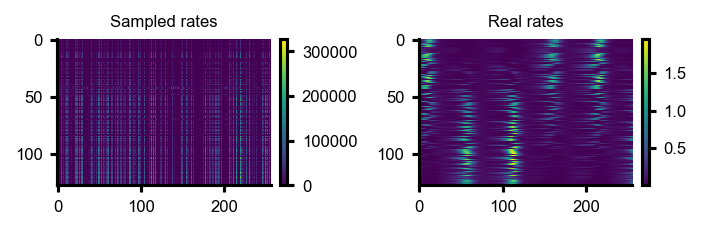

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

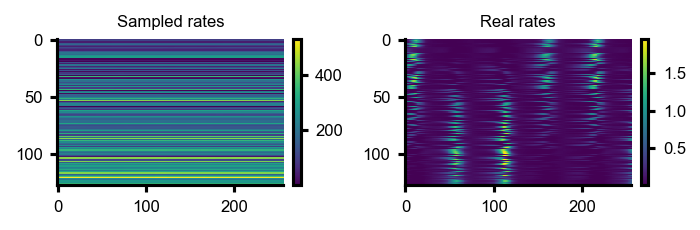

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

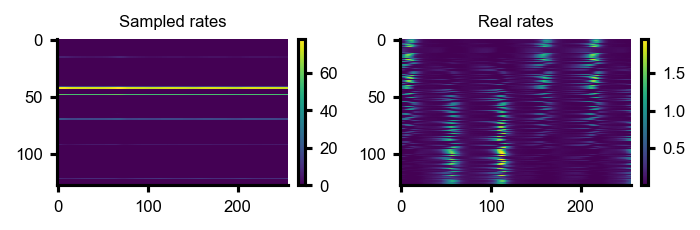

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

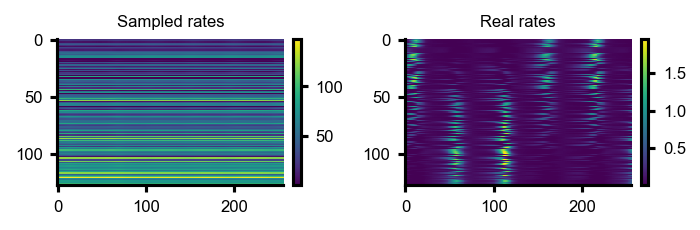

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

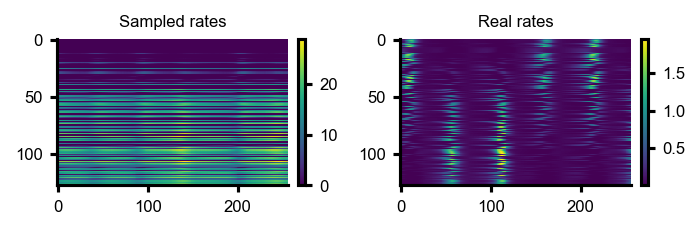

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

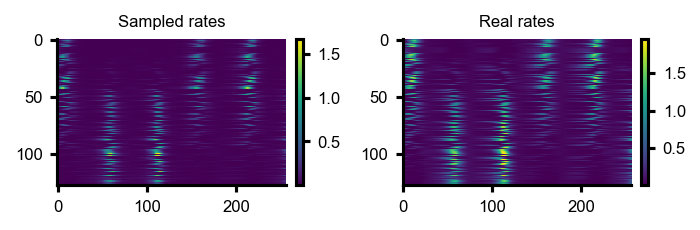

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

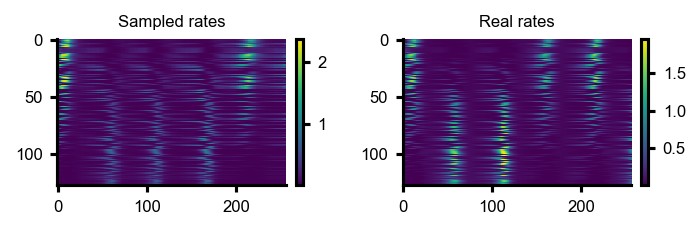

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

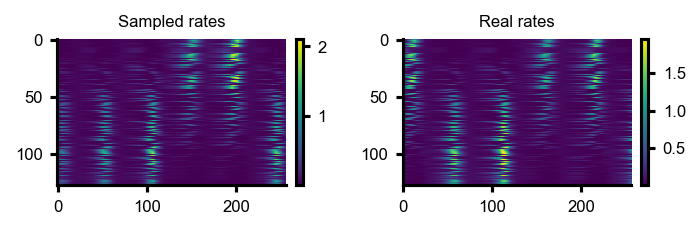

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

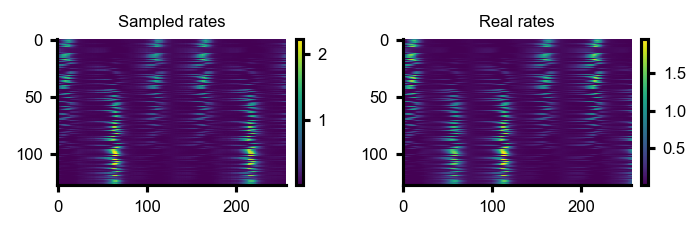

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

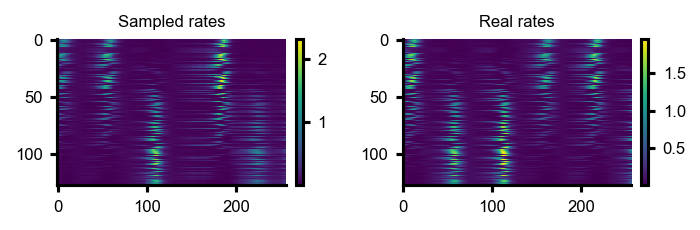

In [15]:
# sampled rates will be very high and erratic at the beginning of the training,
# but will settle down to the true range by the end
# this is expected behavior

pbar = tqdm(range(cfg.training.num_epochs), desc="epochs")
for epoch in pbar:
    for i, batch in enumerate(train_latent_dataloader):

        optimizer.zero_grad()

        z = batch
        t = torch.randint(
            0, cfg.denoiser_model.num_train_timesteps, (z.shape[0],), device="cpu"
        ).long()
        # print(z.shape, t.shape)
        noise = torch.randn_like(z)
        noisy_z = scheduler.add_noise(z, noise, t)
        noise_pred = denoiser(noisy_z, t)

        loss = torch.nn.functional.mse_loss(noise, noise_pred)
        accelerator.backward(loss)
        accelerator.clip_grad_norm_(denoiser.parameters(), 1.0)

        optimizer.step()
        lr_scheduler.step()

        if i % 10 == 0:
            pbar.set_postfix({"loss": loss.item(), "lr": lr_scheduler.get_last_lr()[0]})

        ema_model.step(denoiser)

    if (epoch) % 100 == 0: # plot samples

        sampled_latents = sample(
            ema_denoiser=ema_model, scheduler=scheduler, cfg=cfg, batch_size=2, device="cuda"
        )
        sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
            sampled_latents.device
        ) + latent_dataset_train.latent_means.to(sampled_latents.device)
        with torch.no_grad():
            sampled_rates = ae_model.decode(sampled_latents).cpu()

        fig, ax = plt.subplots(1, 2, figsize=cm2inch(12,4))
        im = ax[0].imshow(sampled_rates[0], aspect='auto')
        ax[0].set_title("Sampled rates")
        fig.colorbar(im, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)

        im = ax[1].imshow(train_dataloader.dataset.dataset[0]["rates"], aspect='auto')
        ax[1].set_title("Real rates")
        fig.colorbar(im, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)
        fig.tight_layout()
        plt.show()

pbar.close()

/tmp/ipykernel_566228/1734155592.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoiser.load_state_dict(torch.load(f"exp/{cfg.exp_name}/model.pt", map_location="cpu")

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

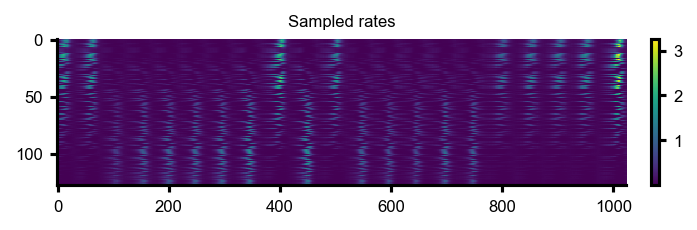

In [16]:
save_new_model = False
load_model = True

os.makedirs('exp/'+cfg.exp_name, exist_ok=True)
if save_new_model:

    # save model and config file
    if accelerator.is_main_process:
        os.makedirs(f"exp/{cfg.exp_name}", exist_ok=True)
        torch.save(accelerator.unwrap_model(denoiser).state_dict(), f"exp/{cfg.exp_name}/model.pt")
        with open(f"conf/{cfg.exp_name}.yaml", "w") as f:
            f.write(OmegaConf.to_yaml(cfg))
    print('saved model to ', cfg.exp_name)
            
elif load_model:
    # load the congig and model path
    with open(f"conf/{cfg.exp_name}.yaml") as f:
        cfg = OmegaConf.create(yaml.safe_load(f))

    denoiser = Denoiser(
        C_in=cfg.denoiser_model.C_in,
        C=cfg.denoiser_model.C,
        L=cfg.dataset.signal_length,
        num_blocks=cfg.denoiser_model.num_blocks,
        bidirectional=cfg.denoiser_model.get("bidirectional", True),
    )

    denoiser.load_state_dict(torch.load(f"exp/{cfg.exp_name}/model.pt", map_location="cpu"))

    scheduler = DDPMScheduler(
        num_train_timesteps=cfg.denoiser_model.num_train_timesteps,
        clip_sample=False,
        beta_schedule="linear", # ddpm doesnt support cosine
    )



    optimizer = torch.optim.AdamW(
        denoiser.parameters(), lr=cfg.training.lr
    )  # default wd=0.01 for now

    train_latent_dataloader = torch.utils.data.DataLoader(
        latent_dataset_train,
        batch_size=cfg.training.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )

    val_latent_dataloader = torch.utils.data.DataLoader(
        latent_dataset_val,
        batch_size=cfg.training.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    test_latent_dataloader = torch.utils.data.DataLoader(
        latent_dataset_test,
        batch_size=cfg.training.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    num_batches = len(train_latent_dataloader)
    lr_scheduler = get_scheduler(
        name="cosine",
        optimizer=optimizer,
        num_warmup_steps=num_batches * cfg.training.num_warmup_epochs,  # warmup for 10% of epochs
        num_training_steps=num_batches * cfg.training.num_epochs * 1.3,  # total number of steps
    )

    # check if signal length is power of 2
    if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
        cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x

    # prepare the denoiser model and dataset
    (
        denoiser,
        train_latent_dataloader,
        val_latent_dataloader,
        test_latent_dataloader,
        lr_scheduler,
    ) = accelerator.prepare(
        denoiser,
        train_latent_dataloader,
        val_latent_dataloader,
        test_latent_dataloader,
        lr_scheduler,
    )

    ema_model = EMAModel(denoiser)


# 4x longer signal length generation

sampled_latents = sample(
    ema_denoiser=ema_model, scheduler=scheduler, cfg=cfg, batch_size=2, device="cuda", signal_length=cfg.dataset.signal_length * 4
)
sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
    sampled_latents.device
) + latent_dataset_train.latent_means.to(sampled_latents.device)
with torch.no_grad():
    sampled_rates = ae_model.decode(sampled_latents).cpu()

fig, ax = plt.subplots(1, 1, figsize=cm2inch(12,4))
im = ax.imshow(sampled_rates[0], aspect='auto')
ax.set_title("Sampled rates")
fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()


Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

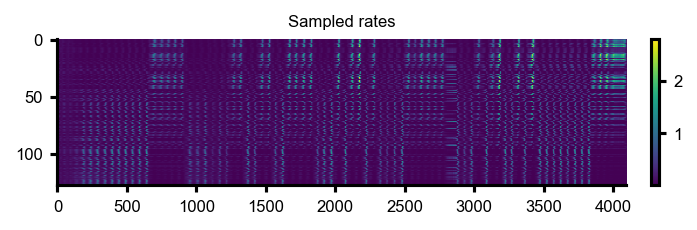

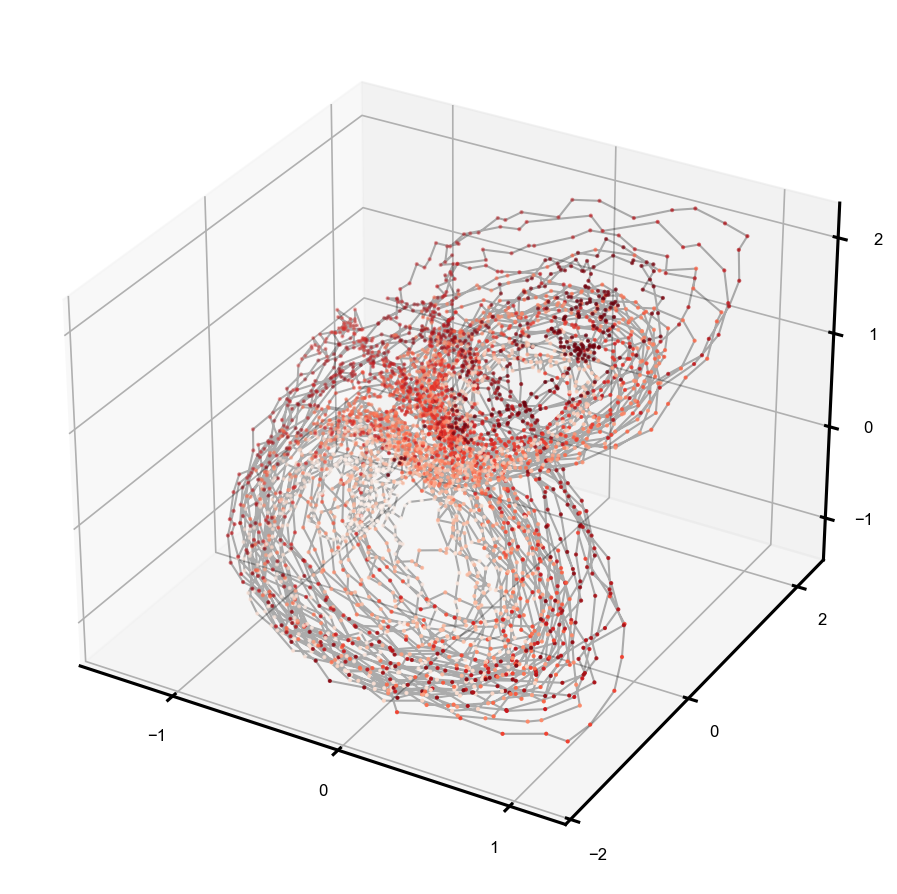

In [20]:
from ldns.utils.plotting_utils import plot_3d_latent_trajectory_direct
    
# 16x longer signal length generation

sampled_latents = sample(
    ema_denoiser=ema_model, scheduler=scheduler, cfg=cfg, batch_size=10, device="cuda", signal_length=cfg.dataset.signal_length * 16
)
sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
    sampled_latents.device
) + latent_dataset_train.latent_means.to(sampled_latents.device)
with torch.no_grad():
    sampled_rates = ae_model.decode(sampled_latents).cpu()

fig, ax = plt.subplots(1, 1, figsize=cm2inch(12,4))
im = ax.imshow(sampled_rates[0], aspect='auto')
ax.set_title("Sampled rates")
fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()
plot_3d_latent_trajectory_direct(sampled_latents, cmap="Reds", indices=[1, 5, 3])


# Evaluation Diffusion on latents

In [17]:

true_data = False
n_siglen = 1
sample_cutoff = int(10e5)

ae_model.eval()

ae_rates = []
ae_latents = []
diffusion_rates = []
diffusion_latents = []
gt_spikes = []

if not true_data:
    gt_rates = []
    gt_latents = []


count = 0
# autoencoder eval 
for batch in train_dataloader:
    signal = batch["signal"]
    with torch.no_grad():
        output_rates, latent = ae_model(signal)
        #output_rates = ae_model(signal)[0].cpu()
    ae_rates.append(output_rates.cpu())
    ae_latents.append(latent.cpu())
    gt_spikes.append(signal.cpu())
    if not true_data:
        gt_rates.append(batch["rates"].cpu())
        gt_latents.append(batch["latents"].cpu())
    count += 1
    # if count > 1:
    #     break

# concatenate along batch dimension
ae_rates = torch.cat(ae_rates, dim=0)
ae_latents = torch.cat(ae_latents, dim=0)
gt_spikes = torch.cat(gt_spikes, dim=0)
if not true_data:
    gt_rates = torch.cat(gt_rates, dim=0)
    gt_latents = torch.cat(gt_latents, dim=0)
    


# diffusion eval
sampled_latents = sample(
    ema_denoiser=ema_model, scheduler=scheduler, cfg=cfg, batch_size=ae_rates.shape[0], device="cuda", signal_length=cfg.dataset.signal_length * n_siglen
)

# project back to non standardized space
sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
    sampled_latents.device
) + latent_dataset_train.latent_means.to(sampled_latents.device)

with torch.no_grad():
    sampled_rates = ae_model.decode(sampled_latents).cpu()
    
diffusion_rates.append(sampled_rates)
diffusion_latents.append(sampled_latents.cpu())

# concatenate along batch dimension
diffusion_rates = torch.cat(diffusion_rates, dim=0)
diffusion_latents = torch.cat(diffusion_latents, dim=0)

vecs = [ae_rates, ae_latents, diffusion_rates, diffusion_latents, gt_spikes]

if not true_data:
    vecs.append(gt_rates)
    vecs.append(gt_latents)

vecs = [vec.cpu().numpy() for vec in vecs]
vecs = [vec[:sample_cutoff] for vec in vecs]
vecs = [rearrange(vec, 'b n t -> b t n') for vec in vecs]


if not true_data:
    ae_rates, ae_latents, diffusion_rates, diffusion_latents, gt_spikes, gt_rates, gt_latents = vecs
else:
    ae_rates, ae_latents, diffusion_rates, diffusion_latents, gt_spikes = vecs


Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

# generate results

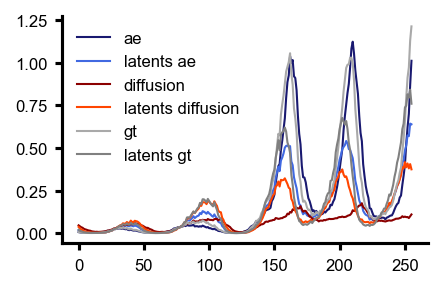

In [23]:
color_dict = {
    "ae": "midnightblue",##2d3047",
    "ael": "royalblue",#"cornflowerblue",#6ca6c1",
    "diff": "darkred",#A44A3F",
    "diffl": "orangered", #84271F",
    # "sim": "#afcb90",
    # "siml": "#495f41",
    "gt": "darkgrey",
    "gtl": "#808080",
}
lab_dict = {
    "ae": "ae",
    "ael": "latents ae",
    "diff": "diffusion",
    "diffl": "latents diffusion",
    "gt": "gt",
    "gtl": "latents gt",
}

# plot all colors 
plt.figure(figsize=cm2inch(8, 5))
for i, (key, color) in enumerate(color_dict.items()):
    plt.plot(ae_rates[0, :, i*4], color=color, label=lab_dict[key])
plt.legend()

Caution: Ensure fps is correct here.... PSD fps: 1


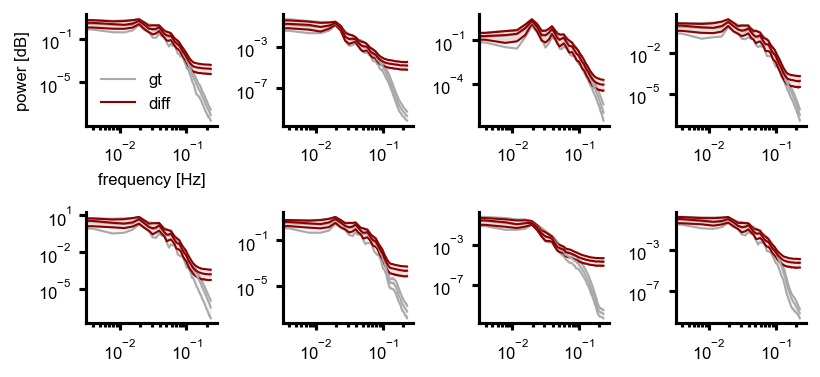

In [23]:
fps=1
plot_n_channel_sd(gt_rates,
                  diffusion_rates,
                  channels=[0, 10, 30, 50, 80, 100, 120, 127], fps=fps,
                  save=False, save_path=None,
                  colors=[color_dict['gt'], color_dict['diff']], 
                  labels=['gt', 'diff'], ystack=2, figsize=cm2inch(14, 6.5), lw=1)

Caution: Ensure fps is correct here.... PSD fps: 1


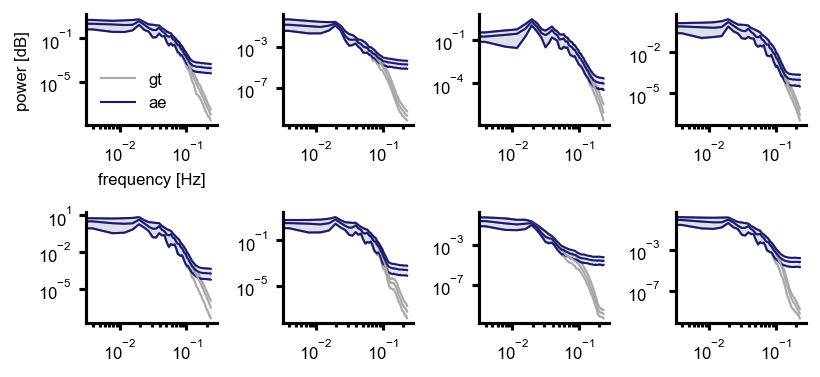

In [24]:

fps=1
plot_n_channel_sd(gt_rates,
                  ae_rates,
                  channels=[0, 10, 30, 50, 80, 100, 120, 127], fps=fps,
                  save=False, save_path=None,
                  colors=[color_dict['gt'], color_dict['ae']], 
                  labels=['gt', 'ae'], ystack=2, figsize=cm2inch(14, 6.5), lw=1)

Caution: Ensure fps is correct here.... PSD fps: 1


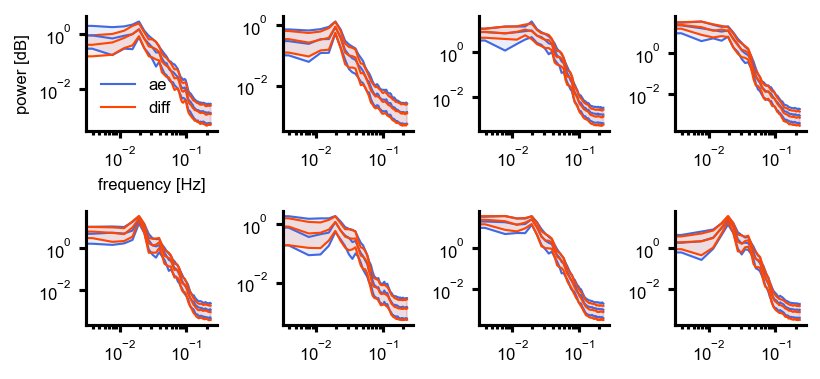

In [25]:
channels = np.random.choice(range(8),8,replace=False)

plot_n_channel_sd(ae_latents,diffusion_latents,
                  channels=channels,
                  fps=fps, save=False, save_path=None,
                  colors=[color_dict['ael'], color_dict['diffl']],
                  labels=['ae', 'diff'], ystack=2, figsize=cm2inch(14, 6.5), lw=1)

Caution: Ensure fps is correct here.... PSD fps: 1


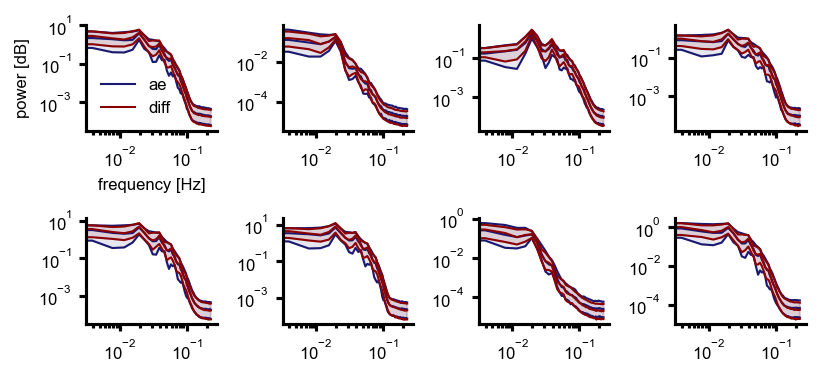

In [26]:
plot_n_channel_sd( ae_rates,diffusion_rates,
                channels=[0, 10, 30, 50, 80, 100, 120, 127],
                  fps=fps,  save=False, save_path=None,
                  colors=[ color_dict['ae'], color_dict['diff']],
                  labels=['ae', 'diff'],ystack=2, figsize=cm2inch(14, 6.5), lw=1)

In [19]:
def group_neurons_by_corr(data, num_groups=4):
    """Group neurons by their overall correlation."""
    C_mat = correlation_matrix(gt_spikes, mode="concatenate")
    np.fill_diagonal(C_mat, 0)
    # sum up the square of the correlations
    summed_sq_corr = np.sum(C_mat ** 2, axis=0)
    sorted_indices = np.argsort(-summed_sq_corr)
    
    # group size 
    group_size = len(sorted_indices) // num_groups
    # split the indices into groups 
    groups = [sorted_indices[i * group_size:(i + 1) * group_size] for i in range(num_groups)]
    return groups

grouped_neurons = group_neurons_by_corr(gt_spikes, num_groups=4)

grouped_neurons

[array([105, 102, 109,  99,  98, 100, 119, 110, 113,  77,  97,  88, 124,
         80,  74,  95,  85, 107, 126,  83,  73,  18,  89,  14,   7, 125,
        116,  64,  15,  34,  37,   5]),
 array([ 58,  68,  60,  41,   0,  16,  53,  50,  71,  79,   2, 123,  43,
         67,   6,  57,  48,  35, 127,   3,  59,  13,  42,  33,  32,  23,
         19,  91,  49,   1,  62,  66]),
 array([ 46,  87,  20,  94, 104,  55,  65,   4,  38,  51,  44,  63, 114,
         70, 117, 121,  54,  75,  25,  31,  69,  40,  56,  61, 108,  81,
         76,  22,  12,  39,  30,  52]),
 array([ 17, 120,  82,  84, 122,  47,  29,  45,  78, 111,  86,  24,  72,
        112,  93,  10,  90,  11,  36,  96,   9,  27,  92,  21,  26,  28,
          8, 101, 118, 115, 103, 106])]

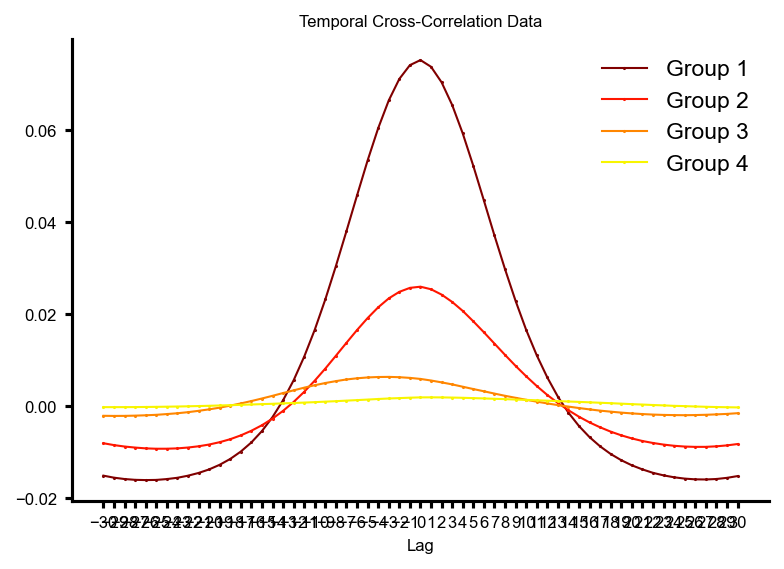

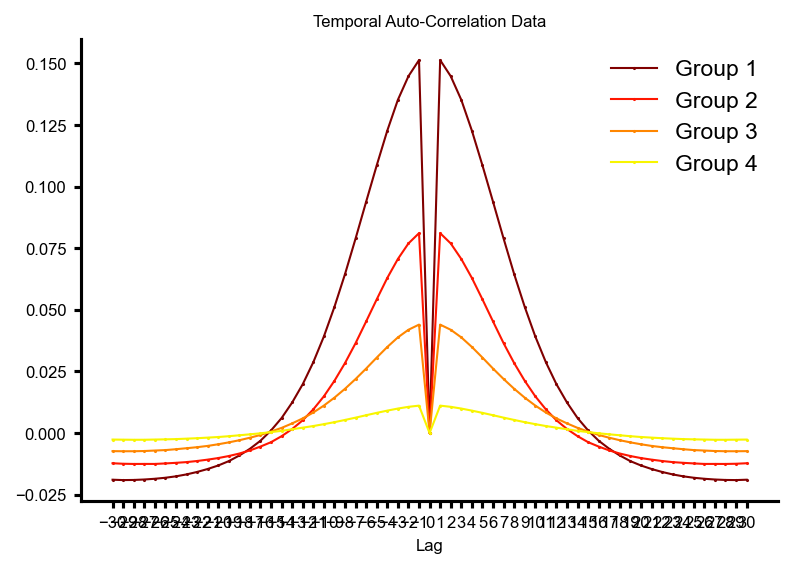

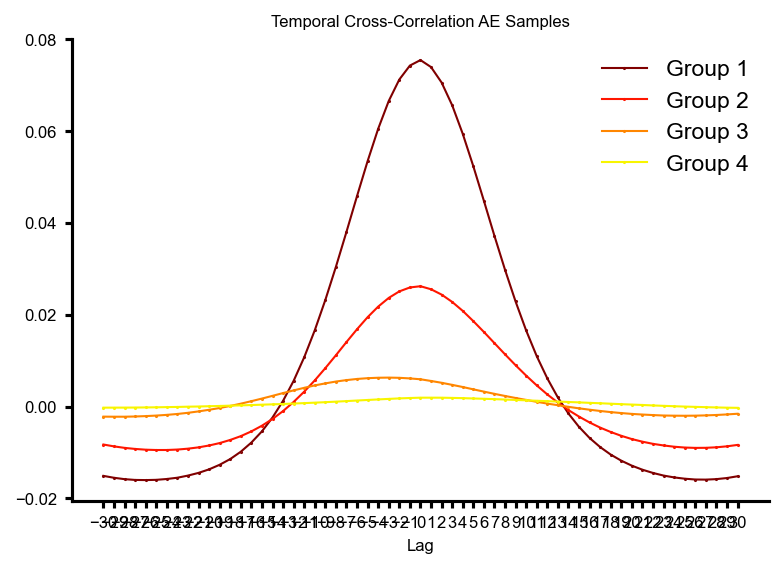

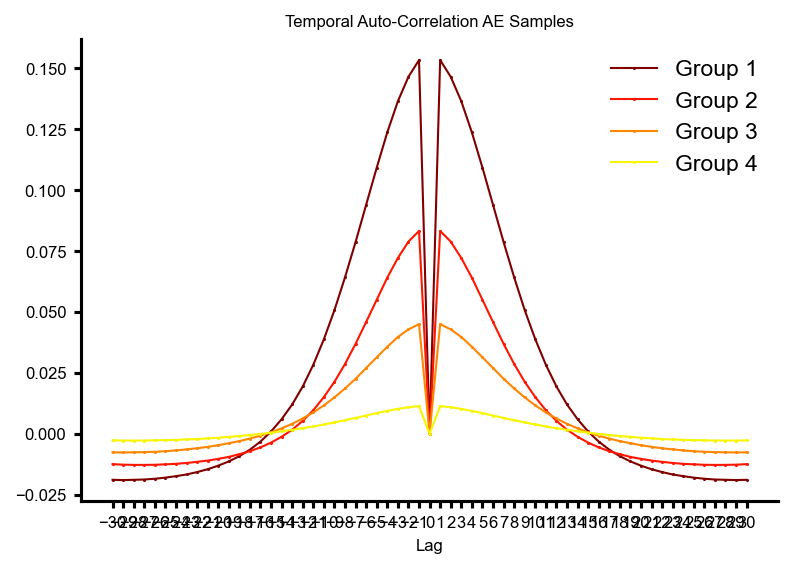

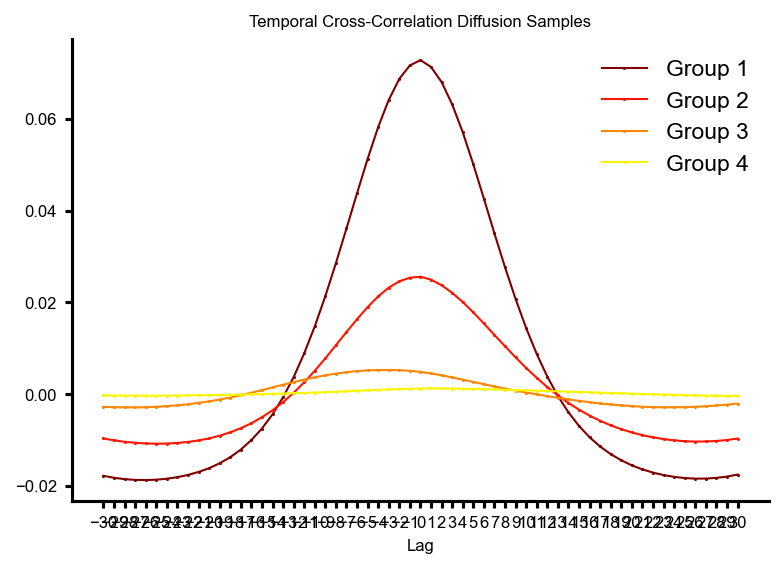

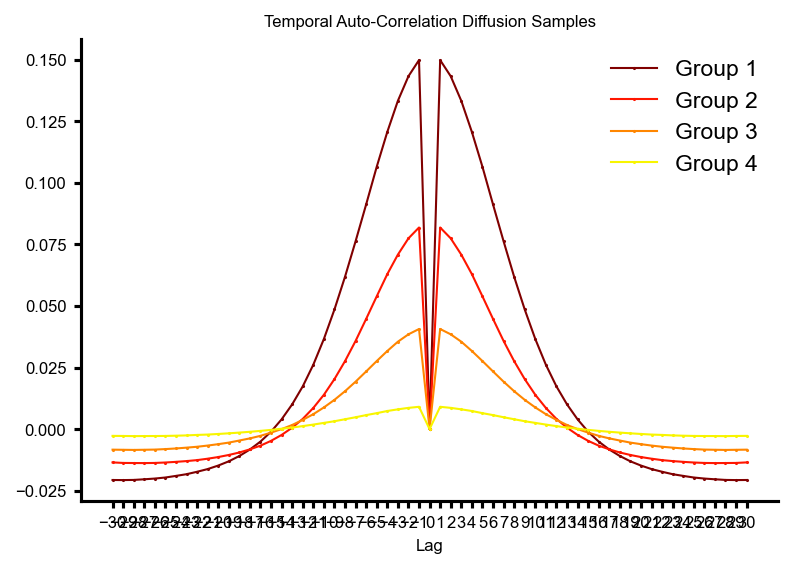

In [20]:
from ldns.utils.eval_utils import group_neurons_temp_corr, get_temp_corr_summary
from ldns.utils.plotting_utils import plot_temp_corr_summary

# group neurons acccording to their correlation to make pairwise correlation plots more efficient to compute
# calculate the time lagged auto correlation and cross correlation for each group
# set correlation of neuron with itself to 0 at lag 0
# this cell will take a while to run

ae_spikes = np.random.poisson(ae_rates)
diff_spikes = np.random.poisson(diffusion_rates)

groups = group_neurons_temp_corr(gt_spikes.transpose(1,0,2), num_groups=4)
cross_corr_groups, auto_corr_groups = get_temp_corr_summary(gt_spikes.transpose(1,0,2), groups, nlags=30,mode='biased',
                                                            batch_first=False)
fig_cross, fig_auto = plot_temp_corr_summary(cross_corr_groups, auto_corr_groups, name='Data')

cross_corr_groups_sampled, auto_corr_groups_sampled = get_temp_corr_summary(ae_spikes.transpose(1,0,2), groups, nlags=30, mode='biased',
                                                            batch_first=False)
fig_cross_sampled, fig_auto_sampled = plot_temp_corr_summary(cross_corr_groups_sampled, auto_corr_groups_sampled, name='AE Samples')


cross_corr_groups_diff, auto_corr_groups_diff = get_temp_corr_summary(diff_spikes.transpose(1,0,2), groups, nlags=30, mode='biased',
                                                            batch_first=False)
fig_cross_sampled, fig_auto_sampled = plot_temp_corr_summary(cross_corr_groups_diff, auto_corr_groups_diff, name='Diffusion Samples')


<Axes: title={'center': 'temporal auto-corr diffusion'}, xlabel='lag', ylabel='auto-corr'>

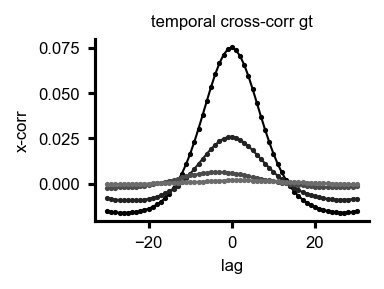

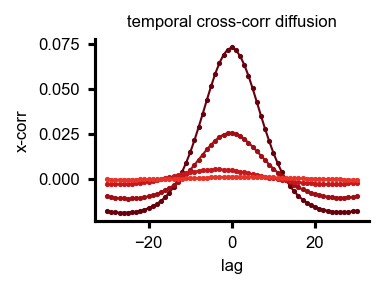

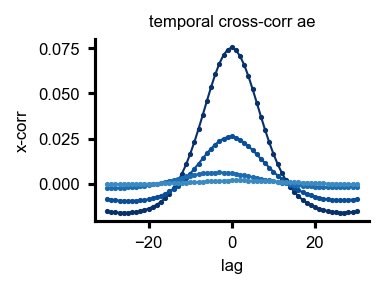

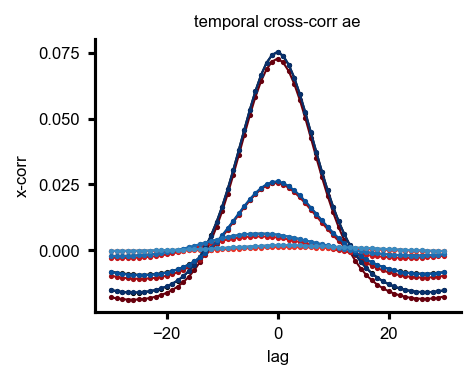

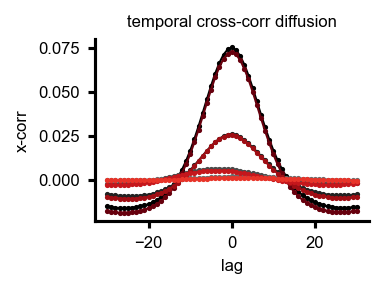

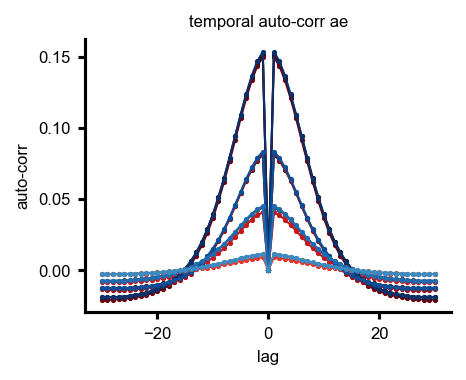

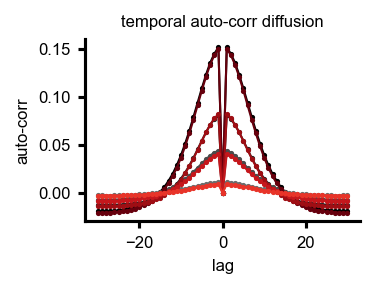

In [21]:
# plot cross correlation summary across temporal lags

from ldns.utils.plotting_utils import plot_cross_corr_summary
plot_cross_corr_summary(
    cross_corr_groups,
    name="gt",
    figsize=cm2inch(6, 4),
    cmap="Greys",
    save=False,
    save_path=None,
)
plot_cross_corr_summary(
    cross_corr_groups_diff,
    name="diffusion",
    figsize=cm2inch(6, 4),
    cmap="Reds",
    save=False,
    save_path=None,
)
plot_cross_corr_summary(
    cross_corr_groups_sampled,
    name="ae",
    figsize=cm2inch(6, 4),
    cmap="Blues",
    save=False,
    save_path=None,
)


fig, ax = plt.subplots(1, 1, figsize=cm2inch(8, 6))
save = False
plot_cross_corr_summary(
    cross_corr_groups,
    name="gt",
    figsize=cm2inch(6, 4),
    cmap="Greys",
    ax_corr=ax,
    labels="gt ",
    ncol=3,
)
plot_cross_corr_summary(
    cross_corr_groups_diff,
    name="diffusion",
    figsize=cm2inch(6, 4),
    cmap="Reds",
    ax_corr=ax,
    labels="diff ",
    ncol=3,
)
plot_cross_corr_summary(
    cross_corr_groups_sampled,
    name="ae",
    figsize=cm2inch(6, 4),
    cmap="Blues",
    ax_corr=ax,
    labels="ae ",
    ncol=3,
)
fig, ax = plt.subplots(1, 1, figsize=cm2inch(6, 4))
save = True
plot_cross_corr_summary(
    cross_corr_groups,
    name="gt",
    figsize=cm2inch(6, 4),
    cmap="Greys",
    ax_corr=ax,
    labels="gt ",
    ncol=2,
)
plot_cross_corr_summary(
    cross_corr_groups_diff,
    name="diffusion",
    figsize=cm2inch(6, 4),
    cmap="Reds",
    ax_corr=ax,
    labels="diff ",
    ncol=2,
)
fig, ax = plt.subplots(1, 1, figsize=cm2inch(8, 6))
plot_cross_corr_summary(
    auto_corr_groups,
    name="gt",
    figsize=cm2inch(6, 4),
    cmap="Greys",
    ax_corr=ax,
    labels="gt ",
    ncol=3,
    title="auto-corr",
    ylabel="auto-corr",
)
plot_cross_corr_summary(
    auto_corr_groups_diff,
    name="diffusion",
    figsize=cm2inch(6, 4),
    cmap="Reds",
    ax_corr=ax,
    labels="diff ",
    ncol=3,
    title="auto-corr",
    ylabel="auto-corr",
)
plot_cross_corr_summary(
    auto_corr_groups_sampled,
    name="ae",
    figsize=cm2inch(6, 4),
    cmap="Blues",
    ax_corr=ax,
    labels="ae ",
    ncol=3,
    title="auto-corr",
    ylabel="auto-corr",
)
fig, ax = plt.subplots(1, 1, figsize=cm2inch(6, 4))
save = True
plot_cross_corr_summary(
    auto_corr_groups,
    name="gt",
    figsize=cm2inch(6, 4),
    cmap="Greys",
    ax_corr=ax,
    labels="gt ",
    ncol=2,
)
plot_cross_corr_summary(
    auto_corr_groups_diff,
    name="diffusion",
    figsize=cm2inch(6, 4),
    cmap="Reds",
    ax_corr=ax,
    labels="diff ",
    ncol=2,
    title="auto-corr",
    ylabel="auto-corr",
)


# Plot population spike histogram

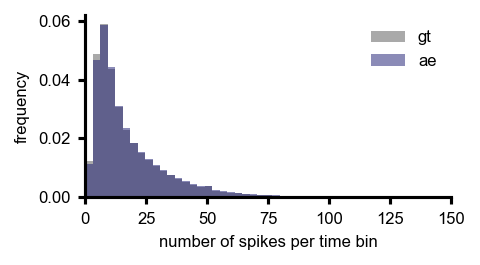

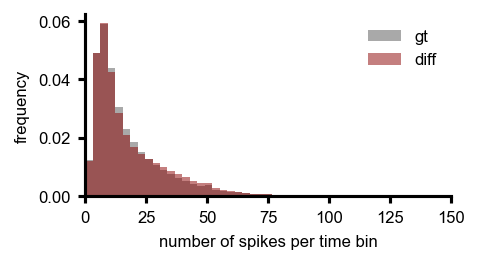

In [26]:

from ldns.utils.plotting_utils import plot_population_spike_histogram
plot_population_spike_histogram(
    gt_spikes,
    np.random.poisson(ae_rates),
    labels=["gt", "ae"],
    colors=[color_dict["gt"], color_dict["ae"]],
    save=False,
    save_path=None,
)
plot_population_spike_histogram(
    gt_spikes,
    np.random.poisson(diffusion_rates),
    labels=["gt", "diff"],
    colors=[color_dict["gt"], color_dict["diff"]],
    save=False,
    save_path=None,
)


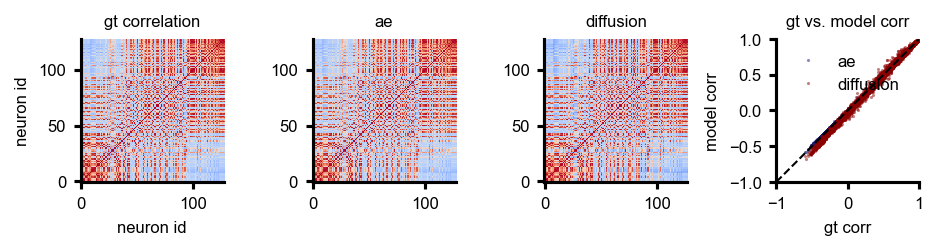

In [27]:
from ldns.utils.eval_utils import correlation_matrix
from ldns.utils.plotting_utils import plot_correlation_matrices


plot_correlation_matrices(
    gt_rates,
    [ae_rates, diffusion_rates],
    sample=None,
    mode="concatenate",
    model_labels=["ae", "diffusion"],
    model_colors=["midnightblue", "darkred"],
    figsize=cm2inch((16, 6)),
    save = False, 
    save_path=None, ms=1
)

In [28]:
# convert counts to spike trains to compute spike train statistics
# this cell will take a while to run

from ldns.utils.eval_utils import counts_to_spike_trains
fps=1
spike_trains_gt = counts_to_spike_trains(gt_spikes, fps=fps)
spike_trains_ae = counts_to_spike_trains(np.random.poisson(ae_rates), fps=fps)
spike_trains_diff = counts_to_spike_trains(np.random.poisson(diffusion_rates), fps=fps)


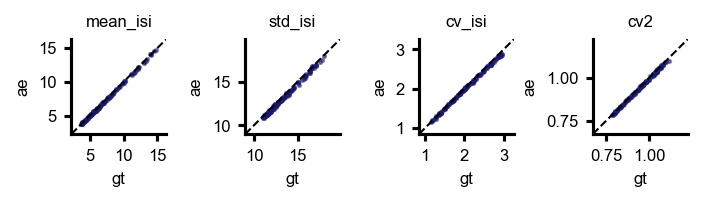

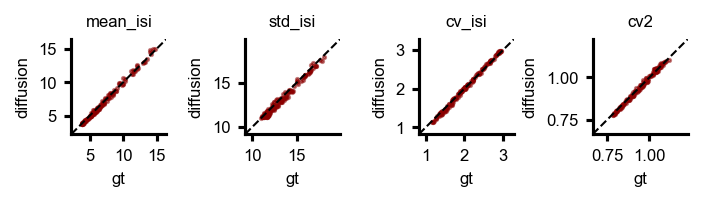

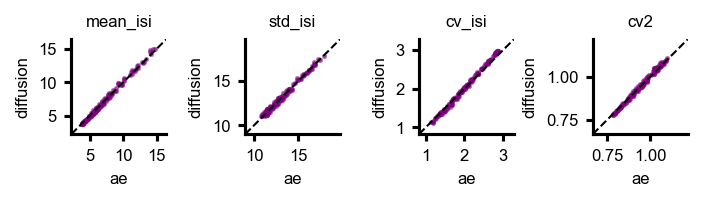

In [29]:
from ldns.utils.eval_utils import compute_spike_stats_per_neuron
from ldns.utils.plotting_utils import cm2inch, plot_spiketrain_stats

spike_stats_gt = compute_spike_stats_per_neuron(
    spike_trains_gt,
    n_samples=gt_spikes.shape[0],
    n_neurons=gt_spikes.shape[2],
    mean_output=False,
)
spike_stats_ae = compute_spike_stats_per_neuron(
    spike_trains_ae,
    n_samples=ae_rates.shape[0],
    n_neurons=ae_rates.shape[2],
    mean_output=False,
)
spike_stats_diff = compute_spike_stats_per_neuron(
    spike_trains_diff,
    n_samples=diffusion_rates.shape[0],
    n_neurons=diffusion_rates.shape[2],
    mean_output=False,
)

plot_spiketrain_stats(
    spike_stats_gt,
    spike_stats_ae,
    figsize=cm2inch(12, 4),
    color="midnightblue",
    labels=["gt", "ae"],
    save = False, 
    save_path=None
)
plot_spiketrain_stats(
    spike_stats_gt,
    spike_stats_diff,
    figsize=cm2inch(12, 4),
    color="darkred",
    labels=["gt", "diffusion"],
    save = False, 
    save_path=None
)
plot_spiketrain_stats(
    spike_stats_ae,
    spike_stats_diff,
    figsize=cm2inch(12, 4),
    color="purple",
    labels=["ae", "diffusion"],
)